In [11]:
import bicycle_model
from enum import Enum
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualizing Maps

In [15]:
FILE = './data/file150.json' # Sample file

# Map types to encodings (NO_DATA->0, VALID->1...)
Encoding = Enum('Encoding', ['NO_DATA', 'VALID', 'NOISE', 'NOISE_INFERRED', 'INFERRED'])

In [13]:
def load_layers(file):
    # Sample read 1 map
    f = open(file)
    data = json.load(f)

    # Map grid/cell xy resolution
    map_resolution = data['map']['info']['resolution']

    # Number of grid cells in x and y
    map_num_x = data['map']['info']['numX']
    map_num_y = data['map']['info']['numY']

    # Left/buttom corner
    map_origin_x = data['map']['info']['poseX']
    map_origin_y = data['map']['info']['poseY']

    # reference to map core data
    map_object = data['map']['object']
    map_observed = data['map']['observed']
    map_terrain = data['map']['terrain']

    object_np = np.zeros((map_num_x, map_num_y))
    observed_np = np.zeros((map_num_x, map_num_y))
    terrain_np = np.zeros((map_num_x, map_num_y))
    for i in range(len(map_object)):
       indX = int(i / map_num_y)
       indY = int(i % map_num_y)

       # Populate object height map
       object_np[indY, indX] = map_object[i]

       observed_np[indY, indX] = map_observed[i]

       if map_observed[i] == Encoding.NOISE:
          observed_np[indY, indX] = Encoding.NO_DATA
       elif map_observed[i] == Encoding.NOISE_INFERRED:
          observed_np[indY, indX] = Encoding.INFERRED

       # Populate terrain map
       terrain_np[indY, indX] = map_terrain[i]

    f.close()

    return object_np, observed_np, terrain_np

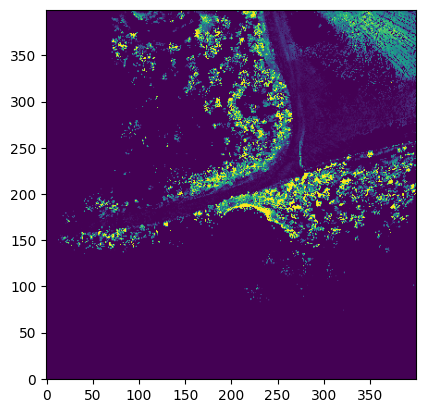

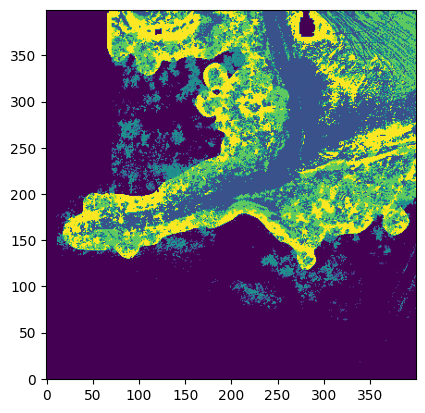

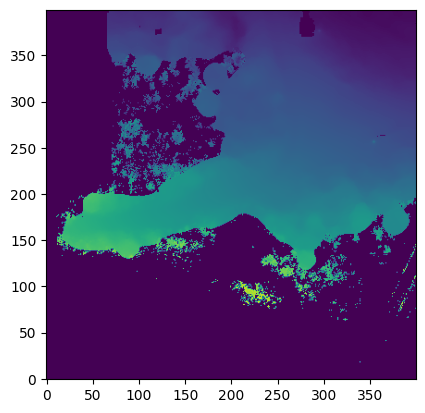

In [14]:
object_np, observed_np, terrain_np = load_layers(FILE)

plt.imshow(object_np, origin ='lower')
plt.show()

plt.imshow(observed_np, origin ='lower')
plt.show()

plt.imshow(terrain_np, origin ='lower')
plt.show()

# Simulating dynamics

In [23]:
params = bicycle_model.Params(max_steering_angle=2, min_steering_angle=-2, dt=3, wheelbase=2.96)

# Simulate dynamics
# for ...
#    new_state = bicycle_model.discrete_dynamics(..., params)